### building a CNN model for the Histopathologic Cancer Detection dataset

The original image is cropped to 32x32 size. We then do the following:

 1. We put it through the first convolution with a kernel size of 3 and a stride length of 1.
 2. The first convolution layer is followed by the MaxPool layer, where images are converted to lower-dimensional 16x16 objects.
 3. This is followed by another convolutional layer with six channels. This convolutional layer is followed by five fully connected layers of feature-length 1,000,500, 250, 120, and 60 to finally get a SoftMax layer that gives the final predictions.  
 
 We will be using **ReLU** as our activation function, **Adam** as our optimizer, and **Cross-Entropy** as our loss function for training this model.

PyTorch Lightning is a versatile framework, which makes training and scaling DL models easy by focusing on building models than writing complex programs.

Here are the steps for building an image classifier using a CNN:

1. Importing the packages
2. Collecting the data
3. Preparing the data
4. Building the model
5. Training the model
6. Evaluating the accuracy of the model

### Importing the packages

In [1]:
!pip install torch==1.10.0 torchvision==0.11.1 torchtext==0.11.0 torchaudio==0.10.0 --quiet

!pip install pytorch-lightning==1.5.2 --quiet

!pip install opendatasets --upgrade --quiet

You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import os

import shutil

import opendatasets as od

import pandas as pd

import numpy as np

from PIL import Image

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import torch

from torch import nn, optim

from torch.utils.data import DataLoader, Dataset

from torch.utils.data.sampler import SubsetRandomSampler

from torchvision.datasets import ImageFolder

import torchvision.transforms as T

from torchvision.utils import make_grid

from torchmetrics.functional import accuracy

import pytorch_lightning as pl

/usr/local/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
print("pandas version:",pd.__version__)

print("numpy version:",np.__version__)

#print("seaborn version:",sns.__version__)

print("torch version:",torch.__version__)

print("pytorch ligthening version:",pl.__version__)

pandas version: 1.4.2
numpy version: 1.21.6
torch version: 1.10.0+cu102
pytorch ligthening version: 1.5.2


### Collecting the data

In [4]:
#dataset_url = 'https://www.kaggle.com/c/histopathologic-cancer-detection'

#od.download(dataset_url)

In [5]:
# train data has 220,000 images and test data has 57,000 images
cancer_labels = pd.read_csv("histopathologic-cancer-detection/train_labels.csv")
cancer_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


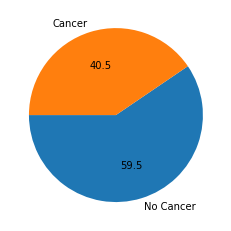

<Figure size 1152x1152 with 0 Axes>

In [11]:
labels_count = cancer_labels.label.value_counts()

plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180, autopct='%1.1f')
plt.figure(figsize=(16,16))
plt.show()

### Preparing the data


It involves the following steps:  
 - Downsampling the data
 - Loading the dataset
 - Augmenting the dataset

In [6]:
#downsample the 220,000 images in the train folder to 10,000 images and then split them into training and testing datasets
np.random.seed(0)

train_imgs_orig = os.listdir("histopathologic-cancer-detection/train")

selected_image_list = []

for img in np.random.choice(train_imgs_orig, 10000):

    selected_image_list.append(img)

len(selected_image_list)

10000

In [7]:
#train-test split
np.random.seed(0)

np.random.shuffle(selected_image_list)

cancer_train_idx = selected_image_list[:8000]

cancer_test_idx = selected_image_list[8000:]

print("Number of images in the downsampled training dataset: ", len(cancer_train_idx))

print("Number of images in the downsampled testing dataset: ", len(cancer_test_idx))

Number of images in the downsampled training dataset:  8000
Number of images in the downsampled testing dataset:  2000


In [8]:
for fname in cancer_train_idx:

    src = os.path.join('histopathologic-cancer-detection/train', fname)

    dst = os.path.join('histopathologic-cancer-detection/train_dataset/', fname)

    shutil.copyfile(src, dst)

In [9]:
for fname in cancer_test_idx:

    src = os.path.join('histopathologic-cancer-detection/train', fname)

    dst = os.path.join('histopathologic-cancer-detection/test_dataset/', fname)

    shutil.copyfile(src, dst)

The labels for the images that were selected in the downsampled data will be extracted in a list that will be used for training and evaluating the image classification model, as shown here:

In [12]:
selected_image_labels = pd.DataFrame()

id_list = []

label_list = []

for img in selected_image_list:

    label_tuple = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0]]

    id_list.append(label_tuple['id'].values[0])

    label_list.append(label_tuple['label'].values[0])

In [13]:
selected_image_labels['id'] = id_list
selected_image_labels['label'] = label_list
selected_image_labels.head()

,id,label
0,f256057c24a792973987c8a9145432ede22f44a1,1
1,4706bd0d1022fd71d764d25a31653db01828277b,1
2,1d67dda911af807586000a7ea39dc4bb781fdfe9,0
3,f020f2b5f831173c4ffb92b637feae8878fba9ac,1
4,55d1b423da9ff472eb23c3be7592501fa90a48ad,1


In [22]:
len(selected_image_labels)

10000

The custom class defined below inherits from the **torch.utils.data.Dataset** module. The LoadCancerDataset custom class is initialized in the __init__ method and accepts three arguments:   
 - the path to the data folder, 
 - the transformer with a default value of cropping the image to size 32 and transforming it to a tensor, and 
 - a dictionary with the labels and IDs of the dataset.

In [16]:
'''
PyTorch Lightning expects data to be in folders with the classes. 
So, we cannot use the DataLoader module directly when all train/test images are in one folder without subfolders. 
Therefore, we will write our custom class for loading the data, as follows:

'''
class LoadCancerDataset(Dataset):

    def __init__(self, 
                 data_folder,    #path to data folder
                 transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), # transformer with a default value of cropping the image to size 32 and transforming it to a tensor
                 dict_labels={} # dict with  labels and IDs of the dataset
                ):

        self.data_folder = data_folder

        self.list_image_files = [s for s in os.listdir(data_folder)]

        self.transform = transform

        self.dict_labels = dict_labels

        self.labels = [dict_labels[i.split('.')[0]] for i in self.list_image_files]

    def __len__(self):

        return len(self.list_image_files)

    def __getitem__(self, idx):

        img_name = os.path.join(self.data_folder, self.list_image_files[idx])

        image = Image.open(img_name)

        image = self.transform(image)

        img_name_short = self.list_image_files[idx].split('.')[0]
        label = self.dict_labels[img_name_short]

        return image, label

In [17]:
# selected_image_labels has all selcted 10,000 images, which are split into test and train dataset
# here we are creating a dictionary to map ID and label 
img_class_dict = {k:v for k, v in zip(selected_image_labels.id, selected_image_labels.label)}

In [18]:
data_T_train = T.Compose([

    T.CenterCrop(32),

    T.RandomHorizontalFlip(),

    T.RandomVerticalFlip(),

    T.ToTensor(),

    ])

data_T_test = T.Compose([

    T.CenterCrop(32),

    T.ToTensor(),

    ])

we will call our LoadCancerDataset custom class with the path to the data folder, transformer, and the image label dictionary to convert it to the format accepted by the torch.utils.data.DataLoader module.

In [20]:
train_set = LoadCancerDataset(  data_folder='histopathologic-cancer-detection/train_dataset/',
                                transform=data_T_train, 
                                dict_labels=img_class_dict  )

In [23]:
test_set = LoadCancerDataset(  data_folder='histopathologic-cancer-detection/test_dataset/',
                                transform=data_T_test, 
                                dict_labels=img_class_dict  )

In [24]:
batch_size = 256

train_dataloader = DataLoader(train_set, batch_size, num_workers=2, pin_memory=True, shuffle=True)

test_dataloader = DataLoader(test_set, batch_size, num_workers=2, pin_memory=True)

### Building the model


Initializing the model  
Configuring the optimizer  
Configuring training and testing  

In [44]:
class CNNImageClassifier(pl.LightningModule):
    def __init__(self, learning_rate = 0.001): # the CNN ImageClassifier class accepts a single parameter—the learning rate, 
                                               # with a default value of 0.001

        super().__init__()

        self.learning_rate = learning_rate
        #Input size (256, 3, 32, 32)

        self.conv_layer1 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)

        #output_shape: (256, 3, 32, 32)

        self.relu1=nn.ReLU()

        #output_shape: (256, 3, 32, 32)

        self.pool=nn.MaxPool2d(kernel_size=2)

        #output_shape: (256, 3, 16, 16)

        self.conv_layer2 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=3,stride=1,padding=1)

        #output_shape: (256, 3, 16, 16)

        self.relu2=nn.ReLU()

        #output_shape: (256, 6, 16, 16)

        #six fully connected linear layers followed by a loss function
        self.fully_connected_1 =nn.Linear(in_features=16 * 16 * 6,out_features=1000) #takes the input, which is the output generated from conv_layer2, 
                                                                                    # and this self.fully_connected_1 layer outputs 1,000 nodes.

        self.fully_connected_2 =nn.Linear(in_features=1000,out_features=500) #takes the output from the first linear layer and outputs 500 nodes

        self.fully_connected_3 =nn.Linear(in_features=500,out_features=250) # takes the output from the 2nd linear layer and outputs 250 nodes

        self.fully_connected_4 =nn.Linear(in_features=250,out_features=120) #takes the output from the 3rd linear layer and outputs 120 nodes

        self.fully_connected_5 =nn.Linear(in_features=120,out_features=60) # takes the output from the 4th linear layer and outputs 60 nodes

        self.fully_connected_6 =nn.Linear(in_features=60,out_features=2) # takes the output from the 5th linear layer and outputs 2 nodes

        self.loss = nn.CrossEntropyLoss()
    # Since this is a binary classification, the output of this NN architecture should be the probability for the two classes. 
    # Finally, we will initialize the loss function, which is cross-entropy loss.

    '''
    Our NN architecture is defined as a combination of CNN and fully connected linear networks, 
    so it's time to pass in the data from the different layers and the activation functions. 
    We will do this with the help of the forward method.
    
    To summarize, in the forward method, the input image data is first passed over the two convolution layers,
    and then the output from the convolution layers is passed over six fully connected layers. 
    Finally, the output is returned.
    
    '''
    def forward(self, input):

        output=self.conv_layer1(input)

        output=self.relu1(output)    

        output=self.pool(output)

        output=self.conv_layer2(output)

        output=self.relu2(output)


        # To pass the output to our linear layers, it is converted to a single-dimensional form, 
        # which can be achieved using the tensor view method
        output=output.view(-1, 6*16*16)

        output = self.fully_connected_1(output)

        output = self.fully_connected_2(output)

        output = self.fully_connected_3(output)

        output = self.fully_connected_4(output)

        output = self.fully_connected_5(output)
        output = self.fully_connected_6(output)

        return output

    '''
    we are using the Adam optimizer with a learning rate that has been initialized in the __init__() method, 
    and we then return the optimizer from this method.

The configure_optimizers method can return up to six different outputs. 
As in the preceding example, it can also return a single list/tuple object. With multiple optimizers, 
it can return two separate lists: one for the optimizers, and a second consisting of the learning-rate scheduler.
    
    '''
    def configure_optimizers(self):

        params = self.parameters()

        optimizer = optim.Adam(params=params, lr = self.learning_rate)

        return optimizer
    
    def training_step(self, batch, batch_idx):

        inputs, targets = batch

        outputs = self(inputs)

        train_accuracy = accuracy(outputs, targets)

        loss = self.loss(outputs, targets)

        self.log('train_accuracy', train_accuracy, prog_bar=True)

        self.log('train_loss', loss)

        return {"loss":loss, "train_accuracy": train_accuracy }
    
    def test_step(self, batch, batch_idx):

        inputs, targets = batch

        outputs = self.forward(inputs)

        #test_accuracy = self.binary_accuracy(outputs,targets)
        test_accuracy = accuracy(outputs,targets)

        loss = self.loss(outputs, targets)

        self.log('test_accuracy', test_accuracy)

        return {"test_loss":loss, "test_accuracy": test_accuracy }



one of the life cycle methods that helps us to train our model on the training dataset is training_step. Similarly, if we want to test our model on the test dataset, we have a life cycle method called test_step.

### Training the model


One of the key features of the PyTorch Lightning framework is the simplicity with which we can train the model. The trainer class comes in handy for doing training along with easy-to-use options such as picking the hardware (cpu/gpu/tpu), controlling training epochs, and all other nice things.

In PyTorch Lightning, to train the model, we first initialize the trainer class and then invoke the fit method to actually train the model.

In [45]:
model = CNNImageClassifier()

trainer = pl.Trainer(max_epochs=5, progress_bar_refresh_rate=50)

trainer.fit(model, train_dataloader=train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

   | Name              | Type             | Params
--------------------------------------------------------
0  | conv_layer1       | Conv2d           | 84    
1  | relu1             | ReLU             | 0     
2  | pool              | MaxPool2d        | 0     
3  | conv_layer2       | Conv2d           | 168   
4  | relu2             | ReLU             | 0     
5  | fully_connected_1 | Linear           | 1.5 M 
6  | fully_connected_2 | Linear           | 500 K 
7  | fully_connected_3 | Linear           | 125 K 
8  | fully_connected_4 | Linear           | 30.1 K
9  | fully_connected_5 | Linear           | 7.3 K 
10 | fully_connected_6 | Linear           | 122   
11 | loss              | CrossEntropyLoss | 0     
--------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.802     Total estimated mode

Training: 0it [00:00, ?it/s]

### Evaluating the accuracy of the model

To calculate the accuracy of the model, we need to pass test data into our test data loader and check the accuracy on the test dataset. 

In [46]:
trainer.test(test_dataloaders=test_dataloader)



Restoring states from the checkpoint path at /home/ju9yt3r/FOLDER_PYTORCH/TEST/lightning_logs/version_4/checkpoints/epoch=4-step=154.ckpt
Loaded model weights from checkpoint at /home/ju9yt3r/FOLDER_PYTORCH/TEST/lightning_logs/version_4/checkpoints/epoch=4-step=154.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.7375565767288208}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.7375565767288208}]